In [1]:
import os

# List all files in the dataset directory
base_path = '/kaggle/input/cleanedtabularcsv/cleaned_train.csv'

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Load the training data
train = pd.read_csv(base_path)
train.head(5)

,id,Basic_Demos-Age,Basic_Demos-Sex,age_group,CGAS_Score,Physical-BMI,BIA_Activity_Level,Fitness_Combined_Score,Physical_Composite_Index,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,Child,51.000000,16.877316,2.0,0.200000,0.184805,64.4,3.0,2.0
1,000fd460,9,0,Early Teen,65.156829,14.035590,2.0,0.400000,0.178587,64.0,0.0,0.0
2,00105258,10,1,Early Teen,65.156829,19.131648,3.0,0.583126,0.193319,54.0,2.0,0.0
3,00115b9f,9,0,Early Teen,71.000000,18.292347,3.0,0.400000,0.190185,45.0,0.0,1.0
4,001f3379,13,1,Teen,50.000000,22.279952,2.0,0.400000,0.217322,56.0,0.0,1.0


In [2]:
# Drop a column by its name
train.drop(['age_group','id'], axis=1, inplace=True)


In [3]:
X = train.drop(columns=['sii'])
y = train['sii']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [6]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


In [7]:
# Check the class distribution after SMOTE
print(pd.Series(y_train_smote).value_counts())

sii
2.0    1271
0.0    1271
1.0    1271
3.0    1271
Name: count, dtype: int64


In [8]:
# 8. Apply PCA to reduce dimensionality after SMOTE (optional but can improve SVM performance)
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, random_state=42)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_smote)
X_val_pca = pca.transform(X_val_scaled)

In [9]:
# Check the explained variance ratio to understand how much information PCA retained
print(f"Explained Variance Ratio by PCA: {np.sum(pca.explained_variance_ratio_)}")

Explained Variance Ratio by PCA: 0.9635096741705508


In [10]:
from sklearn.svm import SVC

# 9. Baseline Model: Train an SVM with a radial basis function (RBF) kernel and class weight balanced
baseline_svm = SVC(kernel='rbf', class_weight='balanced', random_state=42)
baseline_svm.fit(X_train_pca, y_train_smote)


SVC(class_weight='balanced', random_state=42)

In [11]:
# Predict on the validation set
y_pred = baseline_svm.predict(X_val_pca)

In [12]:
print("\nClass distribution in y_pred:")
print(pd.Series(y_pred).value_counts())


Class distribution in y_pred:
0.0    285
1.0    123
2.0    110
3.0     28
Name: count, dtype: int64


In [13]:
# 10. Evaluate the baseline model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print("Baseline Model Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(classification_report(y_val, y_pred))


Baseline Model Performance:
Accuracy: 0.5128205128205128
              precision    recall  f1-score   support

         0.0       0.75      0.67      0.71       318
         1.0       0.33      0.28      0.30       146
         2.0       0.21      0.31      0.25        75
         3.0       0.07      0.29      0.11         7

    accuracy                           0.51       546
   macro avg       0.34      0.39      0.34       546
weighted avg       0.56      0.51      0.53       546



The warning you see occurs because some labels in your validation set (y_val) have no corresponding predicted samples in y_pred. This causes precision and F-score to be undefined for those labels.
Cause: The model did not predict certain classes present in the ground truth (y_val), possibly due to class imbalance, poor model training, or issues with the input features.
Effect: sklearn sets precision and F-score to 0.0 for such labels and warns you about it.

In [14]:
from sklearn.model_selection import GridSearchCV
# 11. Hyperparameter Tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf', 'poly']
}

grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, scoring='f1_weighted', cv=3, n_jobs=-1)
grid_search.fit(X_train_pca, y_train_smote)

# Get the best model after hyperparameter tuning
best_model = grid_search.best_estimator_

# 12. Evaluate the best model from GridSearchCV
y_pred_best = best_model.predict(X_val_pca)

print("Best Model Performance after Hyperparameter Tuning:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_best)}")
print(classification_report(y_val, y_pred_best))


Best Model Performance after Hyperparameter Tuning:
Accuracy: 0.510989010989011
              precision    recall  f1-score   support

         0.0       0.63      0.74      0.68       318
         1.0       0.32      0.25      0.28       146
         2.0       0.15      0.11      0.12        75
         3.0       0.00      0.00      0.00         7

    accuracy                           0.51       546
   macro avg       0.27      0.27      0.27       546
weighted avg       0.47      0.51      0.49       546



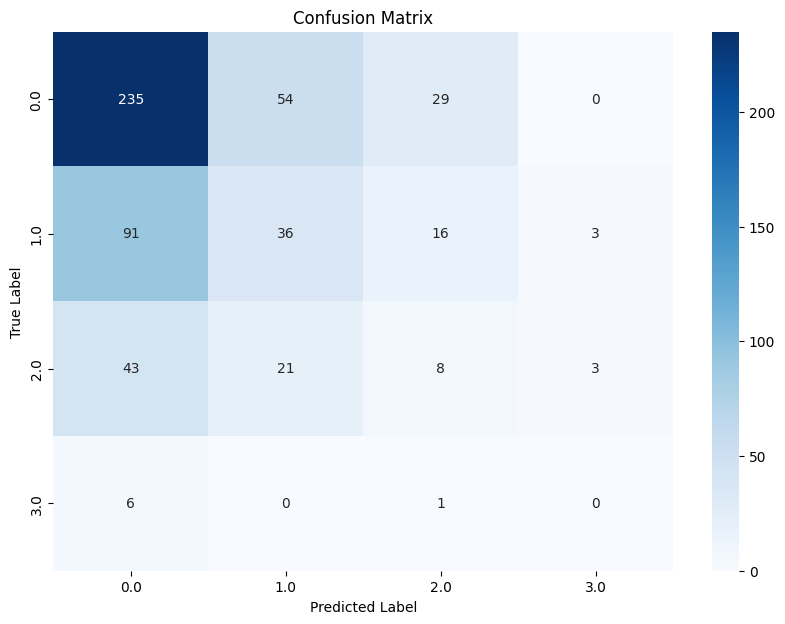

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()